# Staining-based Segmentation

This notebook showcases end-to-end ssDNA staining-based cell segmentation. This is done in two broad steps.

1. Fix any mis-alignments between the staining image and RNA coordinates.
1. Label individual nuclei from the staining image.
2. (Optionally) Expand the nuclei labels to obtain cell labels.

Note that the second step is optional, as there is likely a tradeoff between cell purity (only using the nuclei ends up yielding purer single-cell RNA) and number of UMIs captured per cell (expanding the labels yields higher UMIs per cell).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and opera

In [2]:
adata = st.io.read_bgi_agg('/mnt/e/scratch/stereo/SS200000135TL_D1_Intron_Bin1.txt.gz', '/mnt/e/scratch/stereo/SS200000135IL-D1_mrna.matched.ssDNA.tif', scale=0.5, scale_unit='um')[3000:14000,6000:20000].copy()
adata

AnnData object with n_obs × n_vars = 11000 × 14000
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

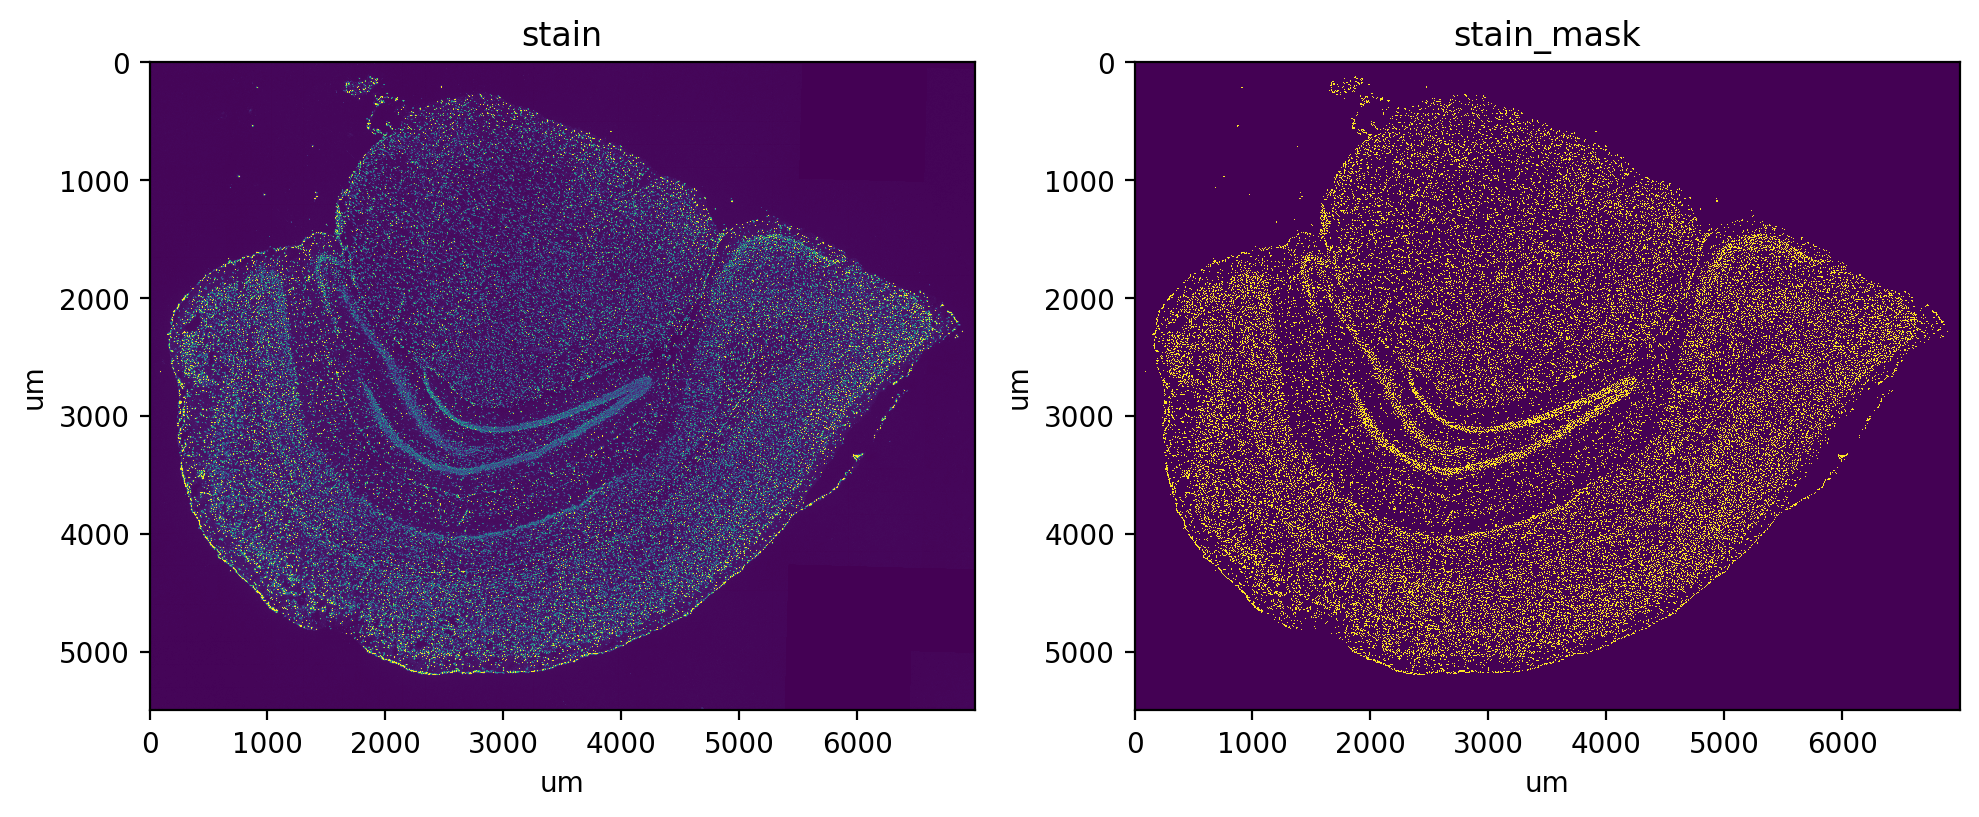

In [3]:
st.pp.segmentation.mask_nuclei_from_stain(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain', ax=axes[0])
st.pl.imshow(adata, 'stain_mask', ax=axes[1])

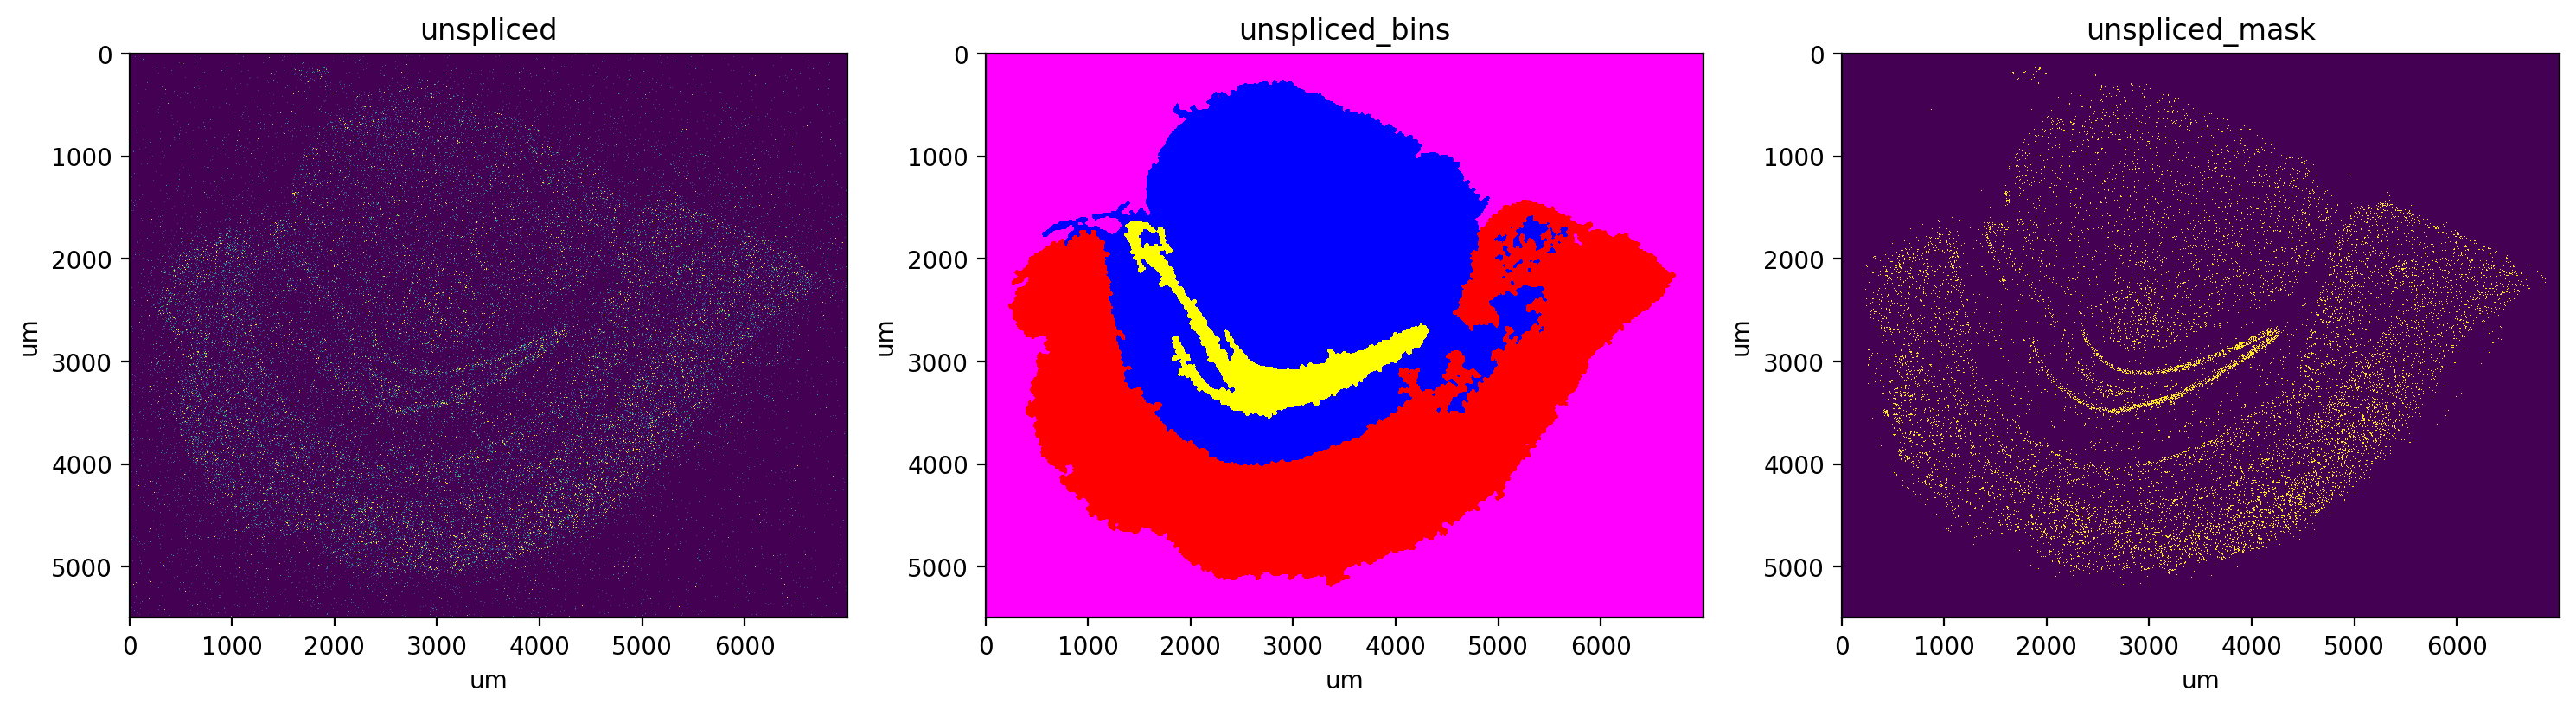

In [25]:
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=7, distance_threshold=6)
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=5, method='EM+BP',
    em_kwargs=dict(downsample=0.001, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
    mk=7,
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced', ax=axes[0], vmax=5)
st.pl.imshow(adata, 'unspliced_bins', ax=axes[1], labels=True)
st.pl.imshow(adata, 'unspliced_mask', ax=axes[2])

Loss 0.2158: 100%|██████████| 100/100 [09:37<00:00,  5.77s/it]


Text(0.5, 1.0, 'superimposed stain_mask and unspliced_mask')

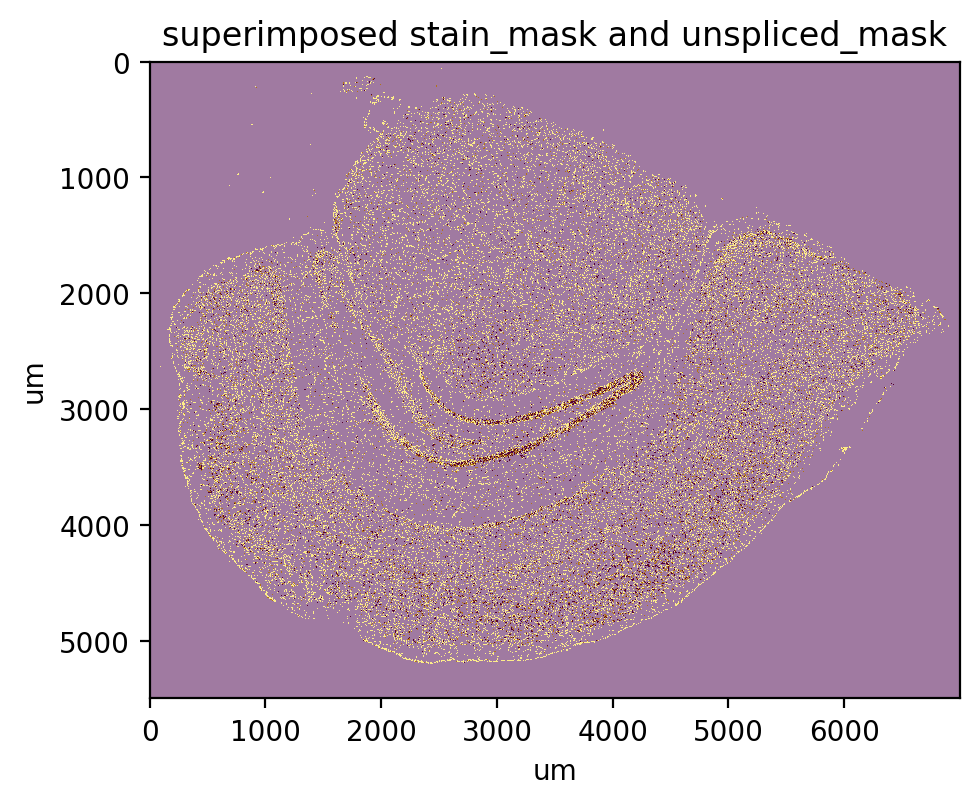

In [26]:
# `transform_layers` specifies which layers should be transformed based on the final affine transformation.
# These layers will be overwridden.
st.pp.segmentation.refine_alignment(adata, transform_layers=['stain', 'stain_mask'])

fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_mask', ax=ax)
st.pl.imshow(adata, 'unspliced_mask', ax=ax, alpha=0.5, cmap='Reds')
ax.set_title('superimposed stain_mask and unspliced_mask')

We can also take a look at the actual affine transformation matrix.

In [27]:
theta = adata.uns['spatial']['alignment']['theta']
scale = theta[0, 0], theta[1, 1]
shear = theta[0, 1], theta[1, 0]
translate = tuple(theta[:,2] * adata.shape)  # Multiply shape because this is normalized

print(scale, shear, translate)

(0.9999721, 0.9999043) (0.00030288124, 0.00050213374) (-15.08199330419302, 6.424808641895652)


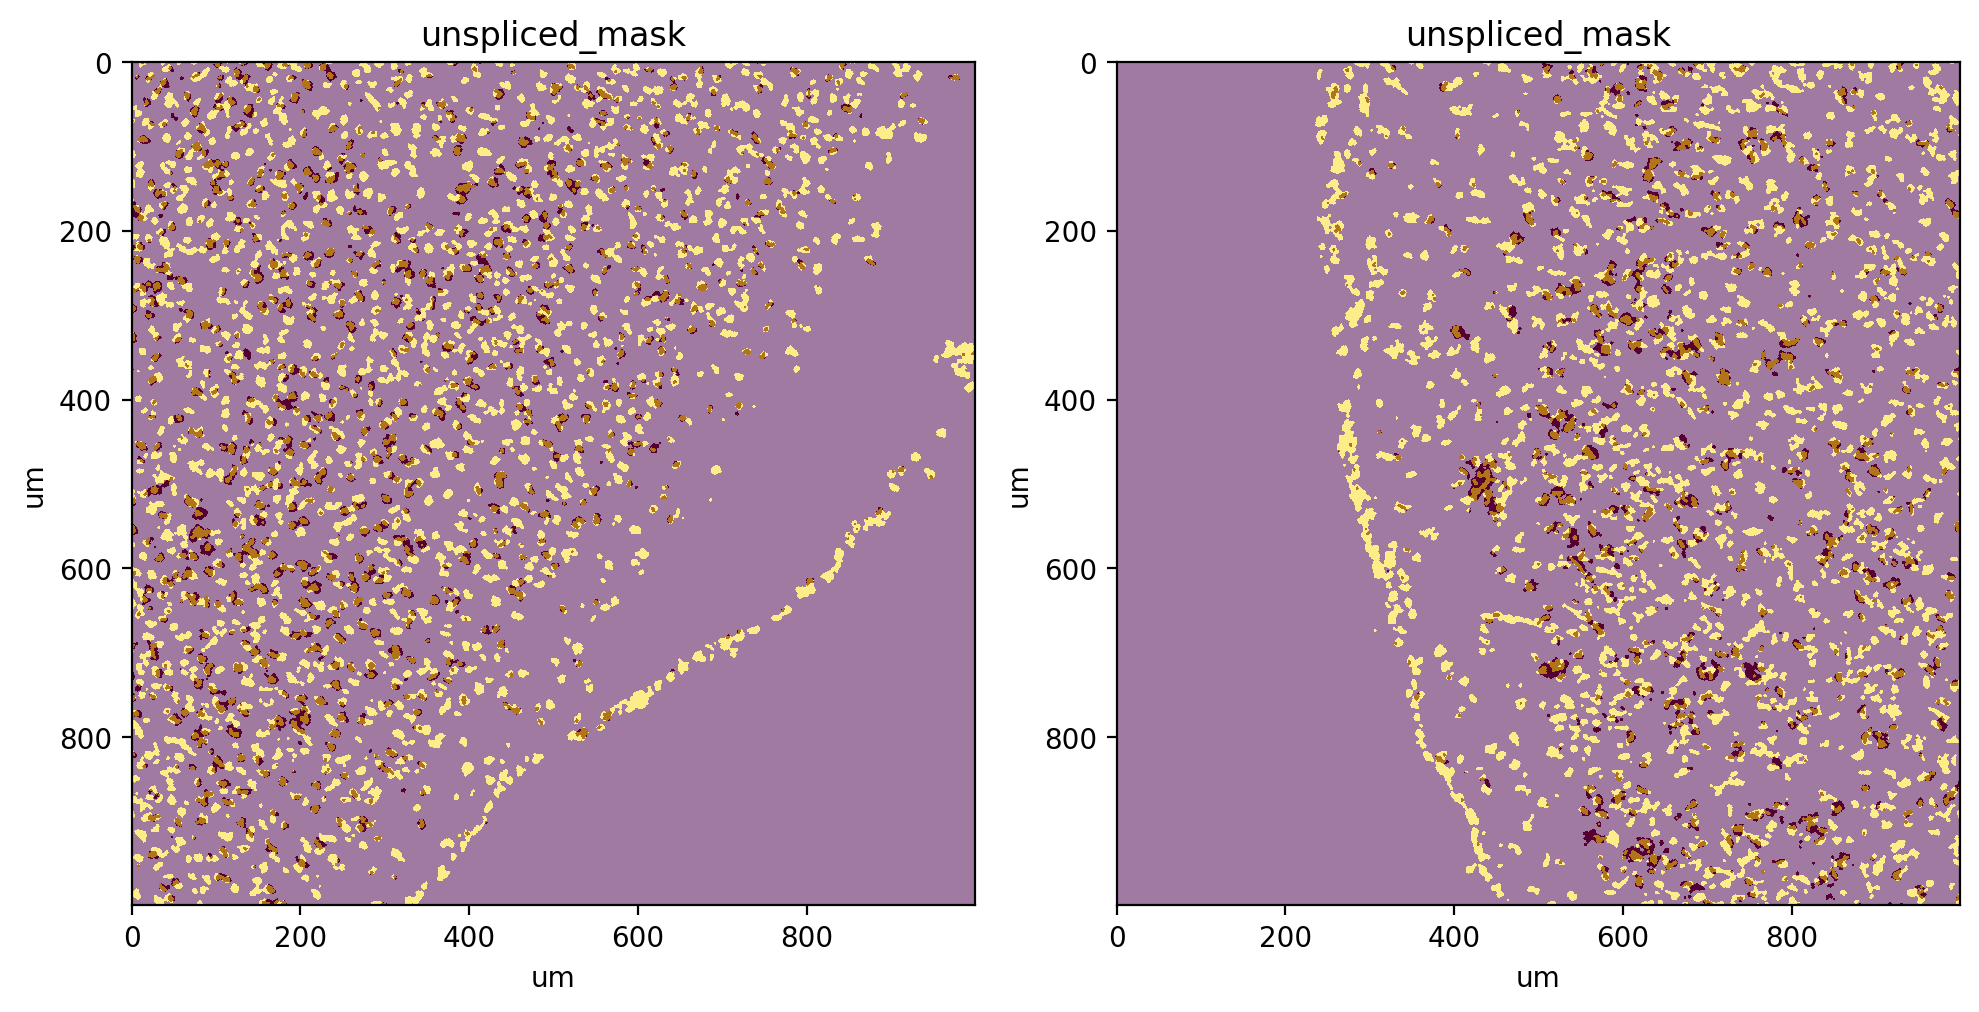

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata[6000:8000,10000:12000], 'stain_mask', ax=axes[0])
st.pl.imshow(adata[6000:8000,10000:12000], 'unspliced_mask', ax=axes[0], alpha=0.5, cmap='Reds')

st.pl.imshow(adata[6000:8000,0:2000], 'stain_mask', ax=axes[1])
st.pl.imshow(adata[6000:8000,0:2000], 'unspliced_mask', ax=axes[1], alpha=0.5, cmap='Reds')

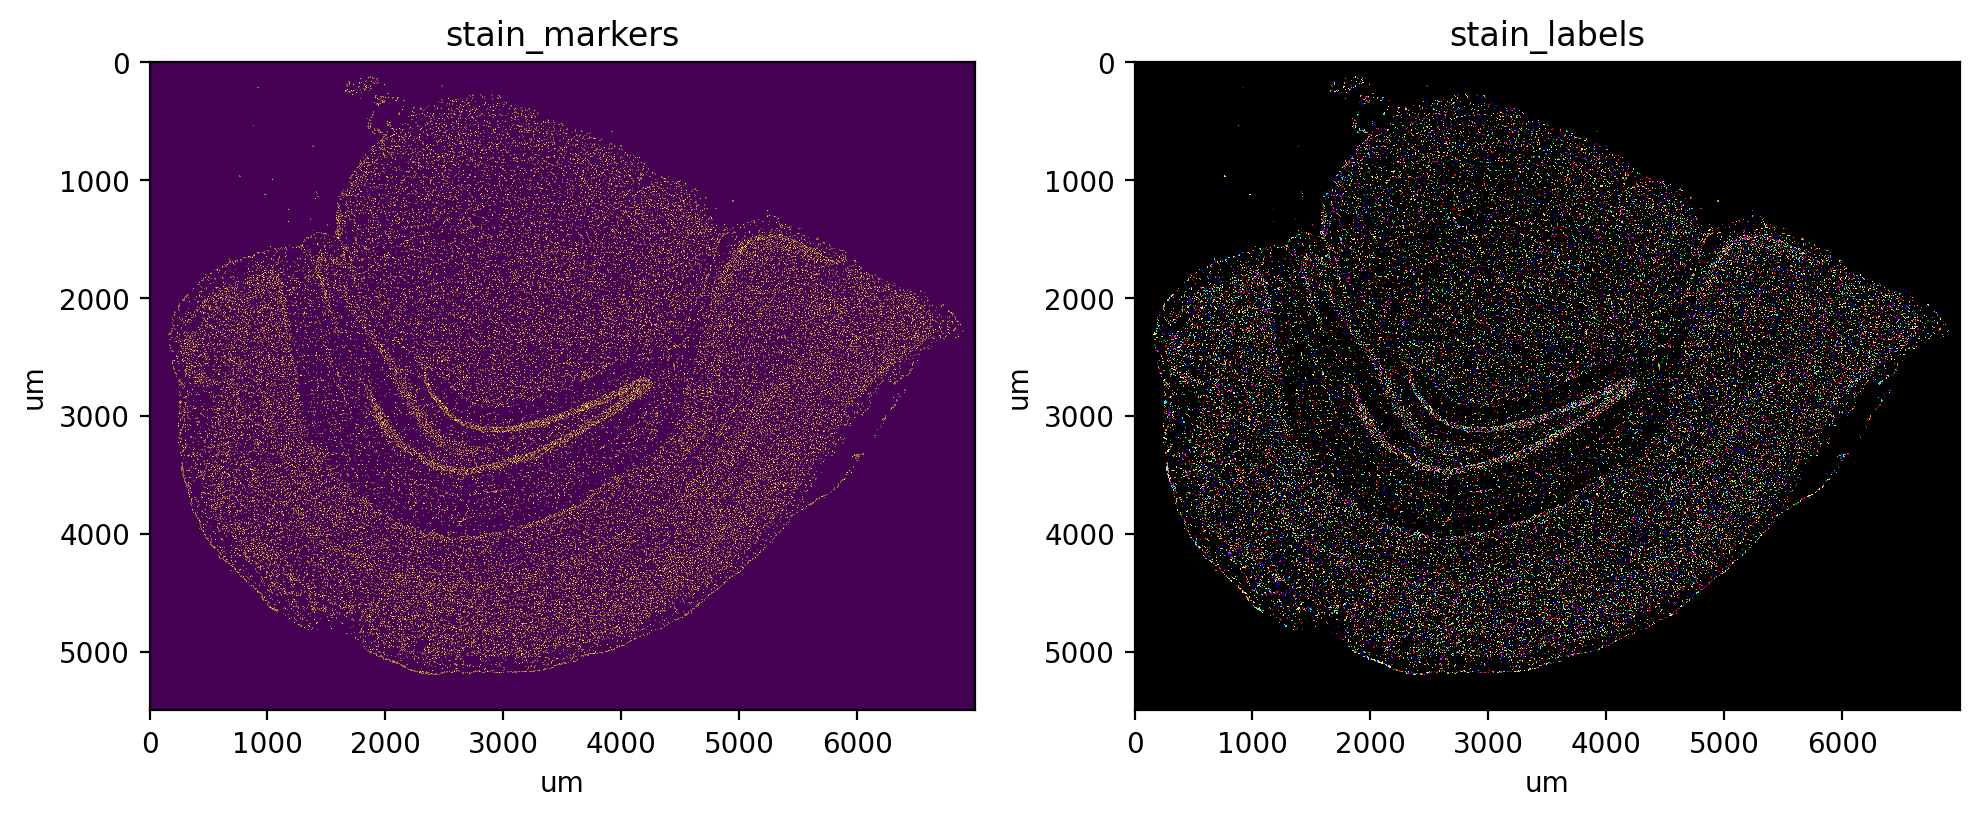

In [32]:
st.pp.segmentation.watershed_markers(adata)
st.pp.segmentation.watershed(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_markers', ax=axes[0], alpha=0.5)

st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)

In [46]:
st.pp.segmentation.expand_labels(adata, 'stain', distance=5, max_area=400)

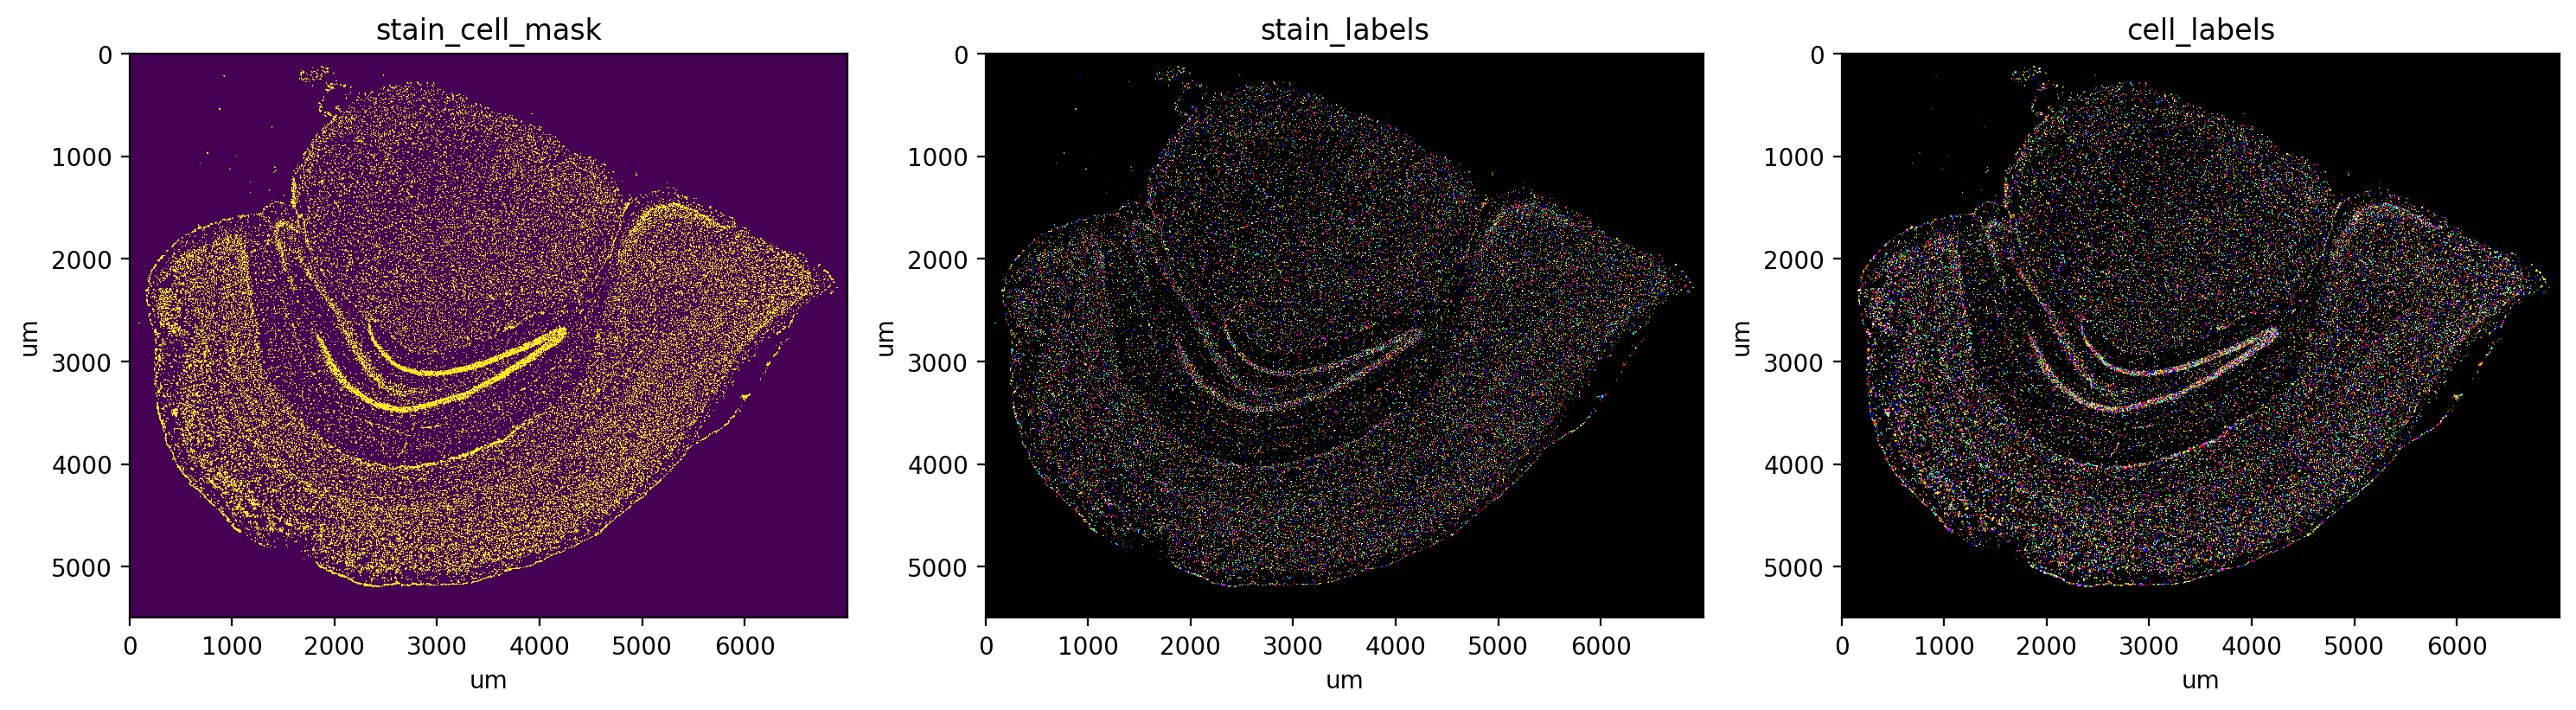

In [34]:
st.pp.segmentation.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.pp.segmentation.watershed(
    adata,
    'stain',
    mask_layer='stain_cell_mask',
    markers_layer='stain_labels',
    out_layer='cell_labels',
)

fig, axes = plt.subplots(ncols=3, figsize=(15, 5), tight_layout=True)
st.pl.imshow(adata, 'stain_cell_mask', ax=axes[0])
st.pl.imshow(adata, 'stain_labels', ax=axes[1], labels=True)
st.pl.imshow(adata, 'cell_labels', ax=axes[2], labels=True)

In [ ]:
st.pp.segmentation.label_connected_components(adata, 'unspliced')
st.pl.imshow(adata, 'unspliced_labels', labels=True)

connectedcomponents
eroding
connectedComponents
expand


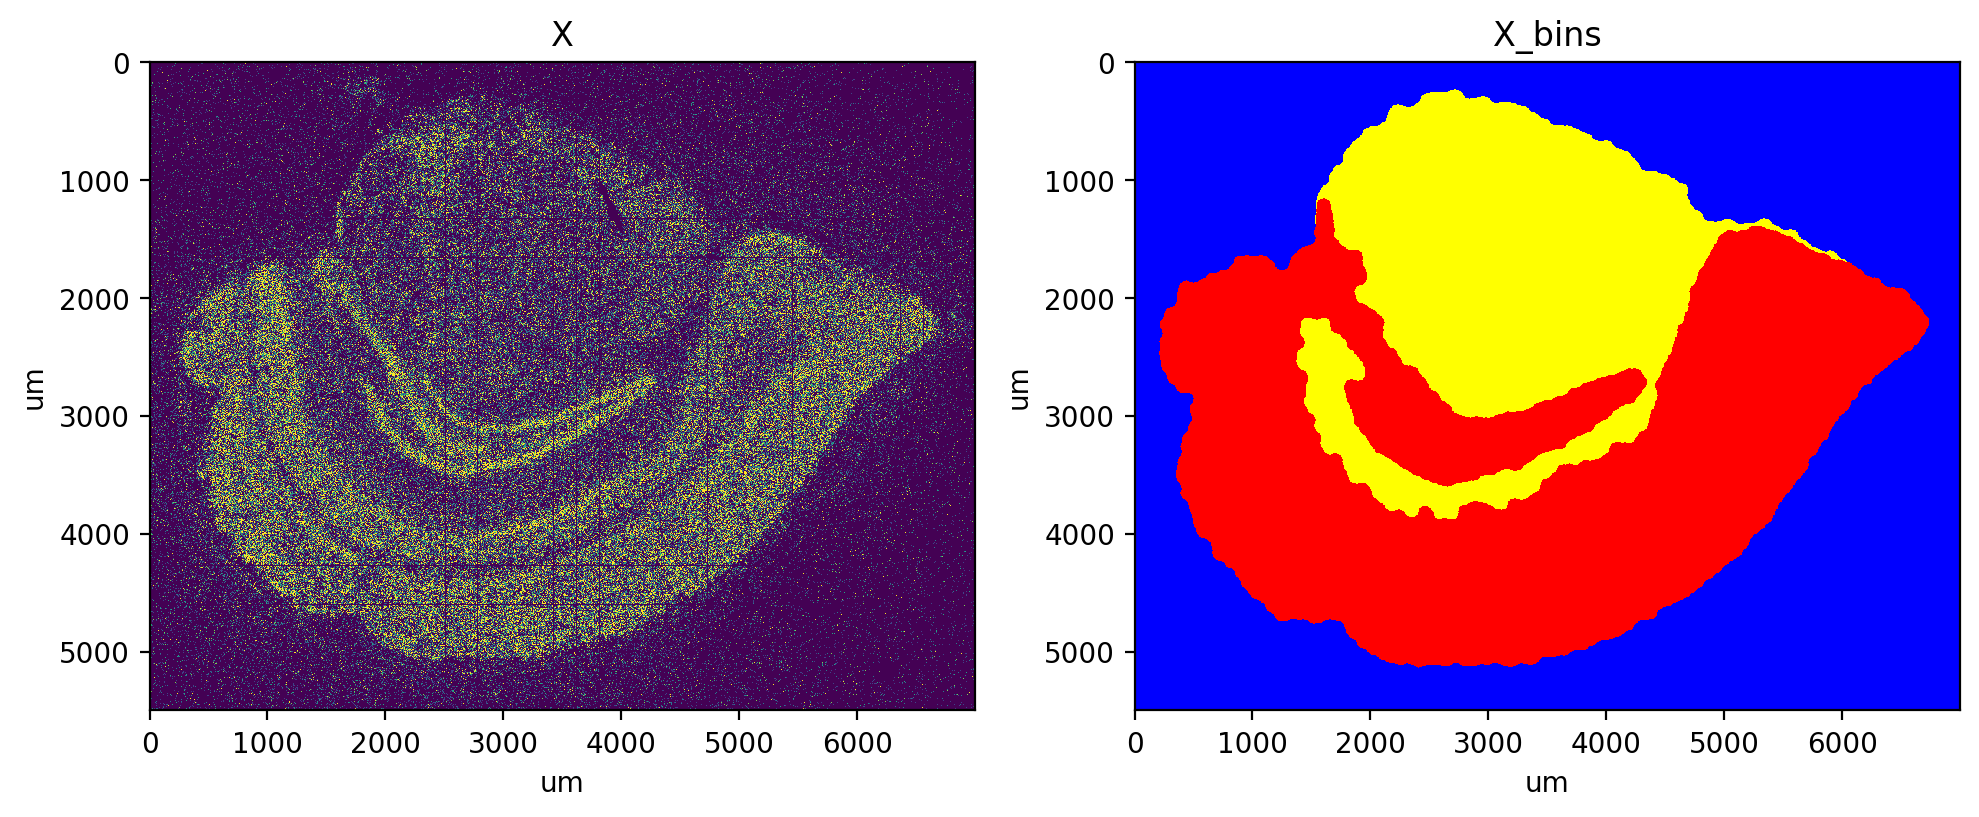

In [38]:
st.pp.segmentation.segment_densities(adata, 'X', 10, k=5, distance_threshold=20, dk=21)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'X', vmax=5, ax=axes[0])
st.pl.imshow(adata, 'X_bins', ax=axes[1], labels=True)

In [ ]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=5, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.9, q=0.1),
    certain_layer='unspliced_labels'
)

In [ ]:
st.pp.segmentation.expand_labels(
    adata, 'unspliced', distance=5, max_area=500, mask_layer='X_mask', out_layer='X_labels'
)
st.pl.imshow(adata, 'X_labels', labels=True)

In [36]:
adata.write('data/full_stain_segmentation.h5ad', compression='gzip')